In [1]:
import numpy as np
from matplotlib import pyplot as plt
import json
from tqdm.notebook import tqdm
import sys
import corner
import matplotlib.image as mpimg

sys.path.append("../")

import tdpy

from binary_planets.sim import get_hill_radius

%load_ext autoreload
%autoreload 2

%matplotlib inline
plt.rcParams.update({
  "text.usetex": True,
  "font.family": "Computer Modern Roman",
  "font.size":    12.0
})


In [2]:
run_systems = np.load("../data/compact_systems_run_composite.npy", allow_pickle=True)

# dirs = ["no_inj", "sin_inj", "bin_inj"]
dirs = ["bin_inj"]

# dirs = ["detailed_no", "detailed_sing", "detailed_bin"]
# dirs = ["binary_inj"]

systems = [sys["name"] for sys in run_systems]

In [3]:
def load_run(i, dir, system, n_err):
    while(True):
        try:
            elements = np.load(f"../output/{dir}/{system}/{i+n_err}/elements.npy")
            distances = np.load(f"../output/{dir}/{system}/{i+n_err}/distances.npy")

            a_i = elements[0, :, 0]

            with open(f"../output/{dir}/{system}/{i+n_err}/config.json") as f:
                cfg = json.load(f)

            if i==1:
                print(f"{dir}:\t {cfg['dt']}")
            with open(f"../output/{dir}/{system}/{i+n_err}/summary.json") as f:
                summary = json.load(f) 
            
            return elements, distances, cfg, summary, n_err
        except Exception as e:
            print(e)
            n_err += 1
            if n_err > 500: 
                return -1, -1, -1, -1, -1
    

    
def load_run_cached(i, dir, system, n_err)
    while(True):
        try:
            elements = np.load(f"../output/{dir}/{system}/{i+n_err}/elements.npy")
            distances = np.load(f"../output/{dir}/{system}/{i+n_err}/distances.npy")

            a_i = elements[0, :, 0]

            with open(f"../output/{dir}/{system}/{i+n_err}/config.json") as f:
                cfg = json.load(f)

            if i==1:
                print(f"{dir}:\t {cfg['dt']}")
            with open(f"../output/{dir}/{system}/{i+n_err}/summary.json") as f:
                summary = json.load(f) 
            
            return elements, distances, cfg, summary, n_err
        except Exception as e:
            print(e)
            n_err += 1
            if n_err > 500: 
                return -1, -1, -1, -1, -1

SyntaxError: expected ':' (2814352608.py, line 26)

In [6]:
t_ends = np.zeros((len(systems), 3000)) * np.nan

max_t = 0
ts = None

for j in tqdm(range(len(systems))):
    dir = dirs[0]
    system = systems[j]
    n_err = 0
    cached_data =  np.load(f"../output/{dir}/{system}/collated_results.npz", allow_pickle=True)

    cached_summaries = cached_data["summaries"]
    cached_cfgs = cached_data["cfgs"]
    cached_elements = cached_data["elements"]
    cached_distances = cached_data["distances"]
    
    for i in range(t_ends.shape[1]):
#         elements = np.load(f"../output/{dir}/{system}/{i}/elements.npy")
#         distances = np.load(f"../output/{dir}/{system}/{i}/distances.npy")


#         with open(f"../output/{dir}/{system}/{i}/config.json") as f:
#             cfg = json.load(f)

#         if i==1:
#             print(f"{dir}:\t {cfg['dt']}")
#         with open(f"../output/{dir}/{system}/{i}/summary.json") as f:
#             summary = json.load(f) 


        try:
            summary = cached_summaries[i]
            cfg = cached_cfgs[i]
            elements = cached_elements[i]
            distances = cached_distances[i]
        except Exception as e:
            t_ends[j, i] = np.nan
            continue

        
#         elements, distances, cfg, summary, n_err = load_run(i, dir, system, n_err)
#         if type(elements) == type(-1):
#             t_ends[j, i] = np.nan
#             continue
        
        a_i = elements[0, :, 0]

        t_stable = summary["t_end"]
    #     print(summary["halt"])


        bin_e = cfg["binary"]["e"]
        bin_a = a_i[1]
        max_d = 1.1 * bin_a * (1 + bin_e)


        for k in range(elements.shape[0]):
            a = elements[k, :, 0]

            if distances[k] > max_d and "bin" in dir:
                t_ends[j, i] = elements[k, 0, 5]
#                 print("Binary Planet unbound")
                break

            if np.any(((a_i-a)/a_i) > 0.1):
                t_ends[j, i] = elements[k, 0, 5]
#                 print(f"Semi-major axes moved: {((a_i-a)/a_i) > 0.1}")
                break
        if t_stable > max_t:
            max_t = t_stable
            ts = elements[:,0,5]
        
        t_ends[j, i] = t_stable

    # print(t_stable)

  0%|          | 0/66 [00:00<?, ?it/s]

Text(0, 0.5, 'Stability Fraction')

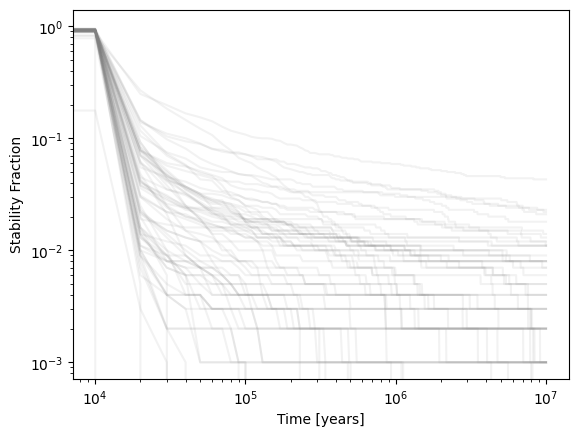

In [17]:
surv_fracs = np.zeros((len(systems), len(ts)))

for i in range(len(systems)):
    surv_fracs[i, :] = np.array([np.sum(t_ends[i,:] >= t-.0001)/len(t_ends[i,:]) for t in ts])
    plt.plot(ts, surv_fracs[i, :], c="grey", alpha=0.1)
    err = np.sqrt(surv_fracs[i, :]*1000)/1000
#     plt.fill_between(ts, surv_fracs[i, :]-err, surv_fracs[i, :]+err, color="grey", alpha=0.01)
    
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Time [years]")
plt.ylabel("Stability Fraction")

In [18]:
large_gap = np.array([sys["gap"][1]/sys["gap"][0] > 1.95 for sys in run_systems])
np.sum(large_gap)

22

/tmp/886292.tmpdir/ipykernel_3508/2327490148.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc=2)


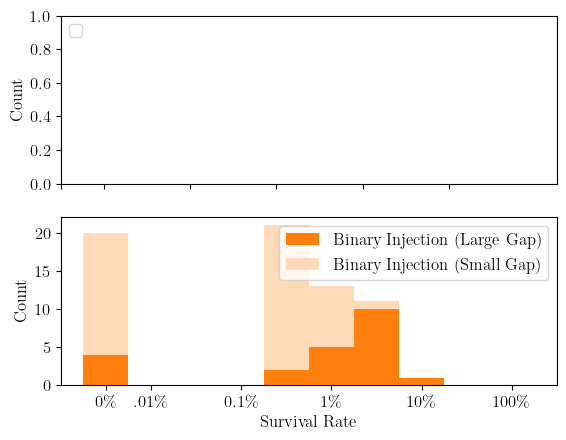

In [26]:
# single_inj_hist = np.array(single_inj)
# single_inj_hist[single_inj_hist < 1e-4] = 10**(-4.7)

# no_inj_hist = np.array(no_inj)
# no_inj_hist[no_inj_hist < 1e-4] = 10**(-4.7)

binary_inj_hist = np.array(surv_fracs[:,-1])
binary_inj_hist[binary_inj_hist < 1e-4] = 10**(-4.7)

colors = ["grey", "blue", "red"]

bins = [-5, -4.5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0]

# plt.subplots(nrows=2, ncols=1)

# plt.hist([np.log10(no_inj_hist),], histtype="stepfilled", 
#          label=["No Injection"],
#         alpha=0.3, color=colors[0], bins=bins)
# plt.hist([np.log10(no_inj_hist)], histtype="step",
#          color=colors[0], bins=bins)
plt.subplot(211)
# plt.hist([ np.log10(single_inj_hist[~large_gap]), np.log10(single_inj_hist[large_gap])], histtype="barstacked", 
#          label=["Single Injection (Small Gap)", "Single Injection (Large Gap)"],
#         alpha=1, color=["lightsteelblue", "tab:blue"], bins=bins, 
#          )


plt.xticks([-4.75, -4.25, -3.25, -2.25, -1.25, -0.25], [r"", r"", r"", r"", r"", r""])
plt.ylabel("Count")

plt.legend(loc=2)

plt.subplot(212)

plt.hist([np.log10(binary_inj_hist[large_gap]), np.log10(binary_inj_hist[~large_gap]),], histtype="barstacked", 
         label=["Binary Injection (Large Gap)", "Binary Injection (Small Gap)"],# hatch=["\\\\\\\\", "\\\\"],
        alpha=1, color=[ "tab:orange", "peachpuff"], bins=bins)

# plt.hist([np.log10(binary_inj_hist)], histtype="step",
#          color="saddlebrown", bins=bins, linewidth=2)

# plt.hist([np.log10(single_inj_hist)], histtype="step",
#          color="black", bins=bins, linewidth=2)







# xticks = [[-3.5, r"<10$^3"]]
plt.xticks([-4.75, -4.25, -3.25, -2.25, -1.25, -0.25], [r"0\%", r".01\%", r"0.1\%", r"1\%", r"10\%", r"100\%"])
plt.legend(loc="best")
plt.xlabel("Survival Rate")
plt.ylabel("Count")
plt.savefig("../figs/survival_hist.png", transparent=True)

In [8]:
# ts = np.linspace(0, np.max(t_ends)-.0001,10000)
# ts = elements[:, 0, 5]

# surv_frac2 = [np.sum(t_ends > t)/len(t_ends) for t in ts]

# no_surv_frac = np.array([np.sum(t_ends[0,:] > t)/len(t_ends[0,:]) for t in ts])
sin_surv_frac2 = np.array([np.sum(t_ends[0,:] >= t-.0001)/len(t_ends[0,:]) for t in ts])
bin_surv_frac2 = np.array([np.sum(t_ends[1,:] >= t-.0001)/len(t_ends[1,:]) for t in ts])


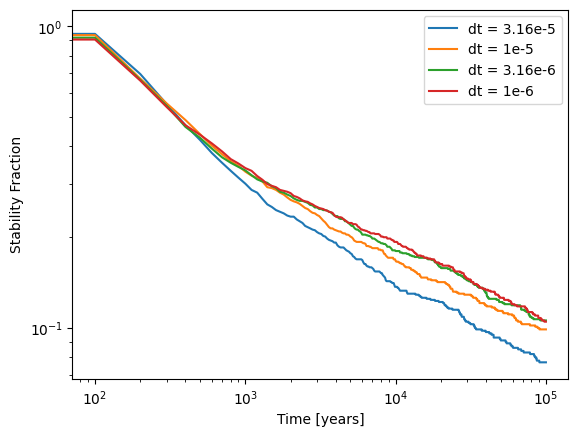

In [12]:
# plt.plot(ts[ts<1e5], no_surv_frac[ts<1e5], label="No Injection")
plt.plot(ts, sin_surv_frac, label="dt = 3.16e-5")
plt.plot(ts, bin_surv_frac, label="dt = 1e-5")
plt.plot(ts, sin_surv_frac2, label="dt = 3.16e-6")
plt.plot(ts, bin_surv_frac2, label="dt = 1e-6")

plt.yscale("log")
plt.xscale("log")
plt.xlabel("Time [years]")
plt.ylabel("Stability Fraction")
plt.legend()
plt.show()

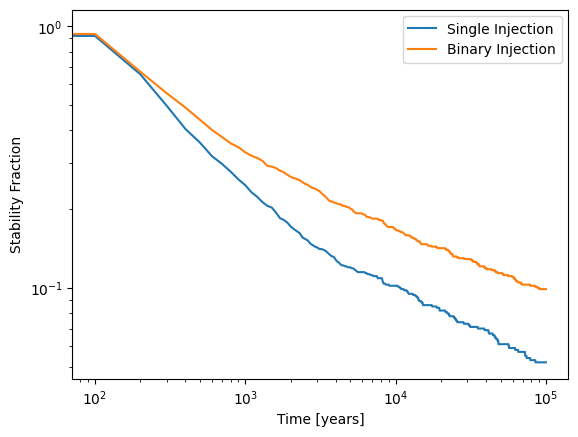

In [8]:
# plt.plot(ts[ts<1e5], no_surv_frac[ts<1e5], label="No Injection")
plt.plot(ts, sin_surv_frac, label="Single Injection")
plt.plot(ts, bin_surv_frac, label="Binary Injection")


plt.yscale("log")
plt.xscale("log")
plt.xlabel("Time [years]")
plt.ylabel("Stability Fraction")
plt.legend()
plt.show()

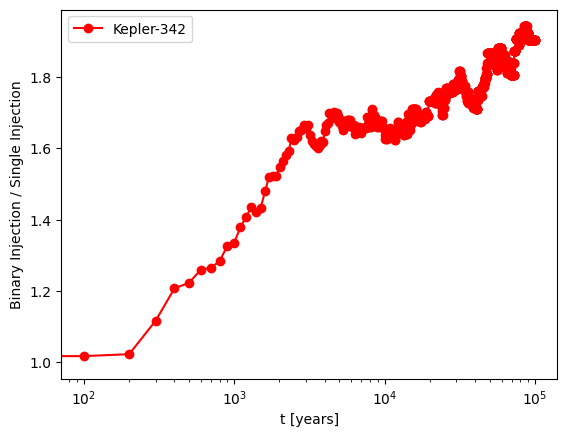

In [9]:
plt.plot(ts, np.array(bin_surv_frac)/np.array(sin_surv_frac),  "ro-", label="Kepler-342")
plt.xlabel("t [years]")
plt.ylabel("Binary Injection / Single Injection")
plt.xscale("log")

# plt.yscale("log")
# plt.xlim(0.0005e7, 1e7)
# plt.ylim(0.25, 0.35)
plt.legend()

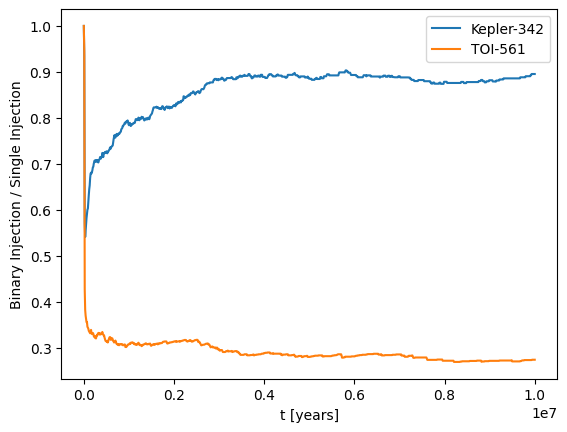

In [26]:
plt.plot(ts, np.array(bin_surv_frac)/np.array(sin_surv_frac), label="Kepler-342")
plt.plot(ts, ratio_TOI, label="TOI-561")
plt.xlabel("t [years]")
plt.ylabel("Binary Injection / Single Injection")
# plt.xscale("log")
# plt.yscale("log")
# plt.xlim(0.0005e7, 1e7)
# plt.ylim(0.25, 0.35)
plt.legend()

In [10]:
# ratio_TOI =  np.array(bin_surv_frac)/np.array(sin_surv_frac)

In [27]:
elements.shape

(1000, 6, 6)

In [37]:
np.sum(t_ends[2,:] == 0)

4817

In [13]:
cfg

{'binary': {'m1': 6.085314149523254,
  'm2': 21.10572666647686,
  'd': 0.0004074537582033781,
  'e': 0.37652058589125303,
  'a': 0.051448552903256735,
  'e_sys': 0.08976059201984843,
  'phase': 1.7279220913940083,
  'Omega': -1.3862160659135427,
  'inc': -2.6317780912553665,
  'bin_inc': -3.069561015195524},
 'n_secondary': 4,
 'secondary_0': {'m': 1.967857313455002,
  'a': 0.010628206583519437,
  'e': 0.0,
  'inc': 0.0,
  'omega': 2.0125833984307286,
  'Omega': -1.3377684352837602},
 'secondary_1': {'m': 5.517185678609276,
  'a': 0.08824408079142901,
  'e': 0.03812136135098798,
  'inc': 0.0,
  'omega': 0.14839444560278903,
  'Omega': -2.3181539776437106},
 'n_log': 1000,
 'integrator': 'leapfrog',
 'dt': 0.0001,
 't_end': 10000000,
 'name': 'bin_7/TOI-561/2999',
 'm_star': 0.810715078668293,
 'secondary_2': {'m': 12.956778963915923,
  'a': 0.1568501653879615,
  'e': 0.10328134239245025,
  'inc': 0.0,
  'omega': 0.728124372364841,
  'Omega': -1.7011731156352023},
 'secondary_3': {'m': 